# Group 26 - Project CaLLaR

### Love isn't only reserved between humans! 

**Project Description:** Our Machine Learning project theme is Love. When we hear that theme for the first time, we thought of love between humans. However, after giving it some thought, why not make a project that focuses on the love between humans and pets? After all, love isn't only reserved between humans! 

For this project, we used Deep Learning to train our models. Librosa and MFCC is also used to extract features for each of our audio. Our hope is that this project could prove usefull to cat lovers who just wants to know more what their cat is saying!


### Packages used

 > Importing useful packages
 
 > Installing librosa for audio analysis
 
 > Installing tensorflow and keras to do Deep Learning

In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import tensorflow as tf
from scipy.io import wavfile
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Reading in metadata of dataset

In [186]:
metadata= pd.read_csv('ML project\data\metadata.csv')
metadata.head()

,slice_file_name,classID,class
0,B_ANI01_MC_FN_SIM01_101.wav,1,brushing
1,B_ANI01_MC_FN_SIM01_102.wav,1,brushing
2,B_ANI01_MC_FN_SIM01_103.wav,1,brushing
3,B_ANI01_MC_FN_SIM01_301.wav,1,brushing
4,B_ANI01_MC_FN_SIM01_302.wav,1,brushing


#### Checking out if dataset is imbalanced

In [187]:
##check wheter the dataset is imbalanced
metadata['class'].value_counts()

isolation           221
brushing            127
waiting_for_food     92
Name: class, dtype: int64

### Looking at the data

### **Waveforms**

##### Example waveform for Brushing audio

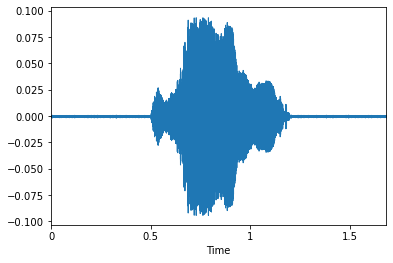

In [188]:
#Brushing
filename='ML project\B_CAN01_EU_FN_GIA01_103.wav'
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)

##### Example waveform for Isolation audio

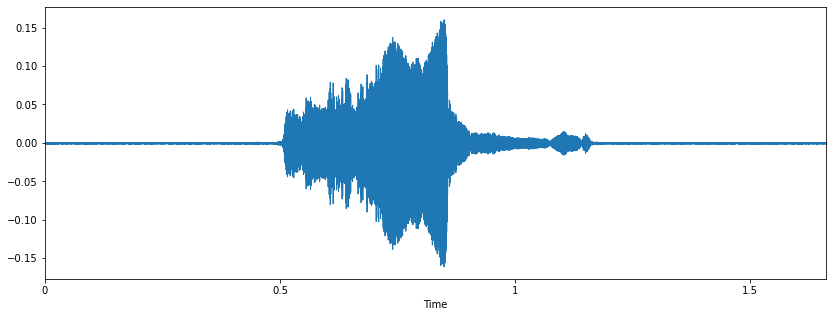

In [189]:
#Isolation
filename='ML project\I_BLE01_EU_FN_DEL01_108.wav'
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)

##### Example waveform for Waiting for Food audio

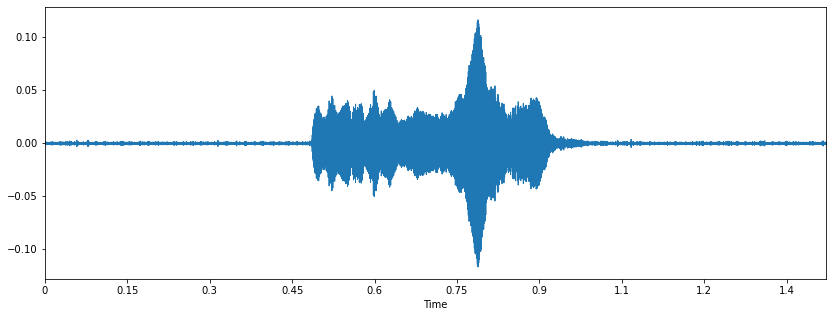

In [190]:
filename='ML project\F_BRI01_MC_FI_SIM01_106.wav'
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)

### **Spectograms**

<ipython-input-191-c135c8b2db59>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplingFrequency, signalData = wavfile.read('ML project\B_CAN01_EU_FN_GIA01_103.wav')


Text(0, 0.5, 'Frequency')

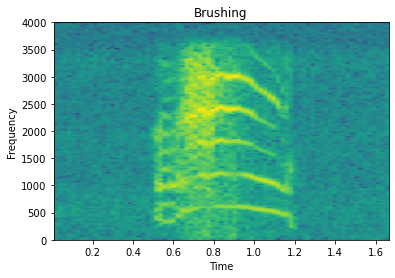

In [191]:
samplingFrequency, signalData = wavfile.read('ML project\B_CAN01_EU_FN_GIA01_103.wav')


plt.title('Brushing')    
Pxx, freqs, bins, im = plt.specgram(signalData,Fs=samplingFrequency,NFFT=300)
plt.xlabel('Time')
plt.ylabel('Frequency')


<ipython-input-192-4ede4e9a92e1>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplingFrequency, signalData = wavfile.read('ML project\I_BLE01_EU_FN_DEL01_108.wav')


Text(0, 0.5, 'Frequency')

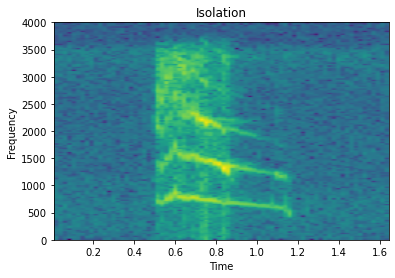

In [192]:
samplingFrequency, signalData = wavfile.read('ML project\I_BLE01_EU_FN_DEL01_108.wav')


plt.title('Isolation')    
Pxx, freqs, bins, im = plt.specgram(signalData,Fs=samplingFrequency,NFFT=300)
plt.xlabel('Time')
plt.ylabel('Frequency')

<ipython-input-193-5115c56e8f71>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplingFrequency, signalData = wavfile.read('ML project\F_BRI01_MC_FI_SIM01_106.wav')


Text(0, 0.5, 'Frequency')

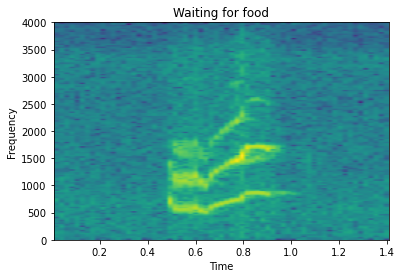

In [193]:
samplingFrequency, signalData = wavfile.read('ML project\F_BRI01_MC_FI_SIM01_106.wav')


plt.title('Waiting for food')    
Pxx, freqs, bins, im = plt.specgram(signalData,Fs=samplingFrequency,NFFT=300)
plt.xlabel('Time')
plt.ylabel('Frequency')

### Using Mel-Frequency Cepstral Coefficients (MFCC) from librosa package to extract features of audio file

#### Loading in the dataset's folder path (that contains the audios) and the audio's dataset

In [194]:
audio_data_path= 'ML project\data\dataset'
metadata= pd.read_csv('ML project\data\metadata.csv')

#### Function to extract features from audio. Features extracted= 40

In [195]:
def features_extractor(file):
    audio,sample_rate= librosa.load(file_name,res_type = 'kaiser_fast')
    mfcss_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features= np.mean(mfcss_features.T,axis=0)
    
    return mfccs_scaled_features

#### Iterating through all audio files to extract each feature by class

In [196]:
#Now we iterate through every audio file and extract features using MFCC
extracted_features=[]
for index_num, row in tqdm (metadata.iterrows()):
    file_name= os.path.join(os.path.abspath(audio_data_path),str(row["slice_file_name"]))
    final_class_label=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_label])

440it [00:06, 63.61it/s]


#### Converting extracted_features to Pandas dataframe

In [197]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-396.81778, 136.41545, -74.92035, -11.478852,...",brushing
1,"[-542.6039, 158.09341, -73.43401, -11.935203, ...",brushing
2,"[-517.51764, 142.89006, -69.55315, -7.46689, 3...",brushing
3,"[-476.4709, 112.17069, -65.29729, -10.651881, ...",brushing
4,"[-511.12573, 135.90286, -62.427002, -11.154292...",brushing


#### Split dataset into independent and dependent dataset

In [198]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

#### Label encoding

In [199]:
y=np.array(pd.get_dummies(y))
#labelencoder = LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))

### Train test split

In [200]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [201]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (352, 40)
X_test:  (88, 40)
y_train:  (352, 3)
y_test:  (88, 3)


#### Initialising the number of output layer nodes based on number of classes

In [202]:
## Number of classes
num_labels=y.shape[1]

## Adding Layers for models and compiling it

In [203]:
def create_model():
  model =Sequential([
        ###first layer
        Dense(100,activation='relu',input_shape=(40,)),
        Dropout(0.5),
        ### second layer
        Dense(200,activation='relu'),
        Dropout(0.5),
        ### third layer
        Dense(100,activation='relu'),        
        Dropout(0.5),
        ### last layer
        Dense(num_labels,activation='softmax')
        
  ])
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
  return model


In [204]:
model=create_model()

#### Model summary

In [205]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               4100      
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                

### Training the model

In [212]:
## Training the model
## features = 40
num_epochs= 100
num_batch_size=32
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpointer=ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,save_best_only=True)
start=datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test,y_test), callbacks= [checkpointer])


duration = datetime.now()- start
print("Training completed in time: ", duration);

Epoch 1/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5927 - accuracy: 0.6875
Epoch 00001: val_loss improved from inf to 0.86405, saving model to training_1\cp.ckpt
11/11 [==============================] - 0s 24ms/step - loss: 0.6106 - accuracy: 0.6562 - val_loss: 0.8640 - val_accuracy: 0.6705
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 0.4274 - accuracy: 0.9062
Epoch 00002: val_loss improved from 0.86405 to 0.78607, saving model to training_1\cp.ckpt
11/11 [==============================] - 0s 17ms/step - loss: 0.6023 - accuracy: 0.6676 - val_loss: 0.7861 - val_accuracy: 0.6591
Epoch 3/100
 1/11 [=>............................] - ETA: 0s - loss: 0.7286 - accuracy: 0.5312
Epoch 00003: val_loss did not improve from 0.78607
11/11 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6534 - val_loss: 0.7925 - val_accuracy: 0.6477
Epoch 4/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5294 - accuracy: 0.6875
Ep

 1/11 [=>............................] - ETA: 0s - loss: 0.5853 - accuracy: 0.7500
Epoch 00030: val_loss did not improve from 0.72221
11/11 [==============================] - 0s 2ms/step - loss: 0.5663 - accuracy: 0.6960 - val_loss: 0.9602 - val_accuracy: 0.6818
Epoch 31/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5345 - accuracy: 0.6250
Epoch 00031: val_loss did not improve from 0.72221
11/11 [==============================] - 0s 3ms/step - loss: 0.5324 - accuracy: 0.6847 - val_loss: 0.8940 - val_accuracy: 0.6932
Epoch 32/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5276 - accuracy: 0.7188
Epoch 00032: val_loss did not improve from 0.72221
11/11 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.6989 - val_loss: 0.9328 - val_accuracy: 0.6705
Epoch 33/100
 1/11 [=>............................] - ETA: 0s - loss: 0.6890 - accuracy: 0.5625
Epoch 00033: val_loss did not improve from 0.72221
11/11 [==============================]

Epoch 60/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5129 - accuracy: 0.7812
Epoch 00060: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.7017 - val_loss: 0.7960 - val_accuracy: 0.7159
Epoch 61/100
 1/11 [=>............................] - ETA: 0s - loss: 0.6054 - accuracy: 0.7188
Epoch 00061: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.7017 - val_loss: 1.0375 - val_accuracy: 0.6818
Epoch 62/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5460 - accuracy: 0.6562
Epoch 00062: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 2ms/step - loss: 0.5831 - accuracy: 0.6847 - val_loss: 0.9977 - val_accuracy: 0.6591
Epoch 63/100
 1/11 [=>............................] - ETA: 0s - loss: 0.6586 - accuracy: 0.6250
Epoch 00063: val_loss did not improve from 0.70558
11/11 [==================

Epoch 90/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5847 - accuracy: 0.6250
Epoch 00090: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 3ms/step - loss: 0.5439 - accuracy: 0.7045 - val_loss: 1.1544 - val_accuracy: 0.7045
Epoch 91/100
 1/11 [=>............................] - ETA: 0s - loss: 0.6054 - accuracy: 0.6875
Epoch 00091: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 3ms/step - loss: 0.5580 - accuracy: 0.6847 - val_loss: 1.1459 - val_accuracy: 0.6932
Epoch 92/100
 1/11 [=>............................] - ETA: 0s - loss: 0.5125 - accuracy: 0.7188
Epoch 00092: val_loss did not improve from 0.70558
11/11 [==============================] - 0s 2ms/step - loss: 0.5873 - accuracy: 0.6818 - val_loss: 1.2003 - val_accuracy: 0.6818
Epoch 93/100
 1/11 [=>............................] - ETA: 0s - loss: 0.4980 - accuracy: 0.7188
Epoch 00093: val_loss did not improve from 0.70558
11/11 [==================

## Accuracy of prediction

In [218]:
test_accurancy=model.evaluate(X_test,y_test,verbose=1)
print(test_accurancy[1])

3/3 [==============================] - 0s 997us/step - loss: 0.9814 - accuracy: 0.7045
0.7045454382896423


### Testing the model by creating a new untrained model and then loading the saved weights to see if the prediction percentage stays the same

In [219]:
# Create a basic model instance
model2 = create_model()

# Evaluate the model
loss, acc = model2.evaluate(X_test, y_test, verbose=1)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

3/3 [==============================] - 0s 665us/step - loss: 31.5889 - accuracy: 0.4886
Untrained model, accuracy: 48.86%


In [220]:
# Loads the weights
model2.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Restored model, accuracy: 69.32%


## Test out the model

#### Confusion Matrix

In [221]:
y_pred = model.predict_classes(X_test)

In [222]:
from sklearn.metrics import confusion_matrix
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred)
matrix

array([[18,  3,  4],
       [ 1, 38,  4],
       [ 6,  8,  6]], dtype=int64)

##### Confusion matrix report

In [223]:
print(metrics.classification_report(y_test.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        25
           1       0.78      0.88      0.83        43
           2       0.43      0.30      0.35        20

    accuracy                           0.70        88
   macro avg       0.64      0.63      0.63        88
weighted avg       0.68      0.70      0.69        88



### ROC graph

C:\Users\lenovo\anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\lenovo\anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\lenovo\anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


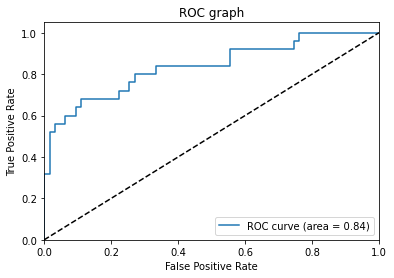

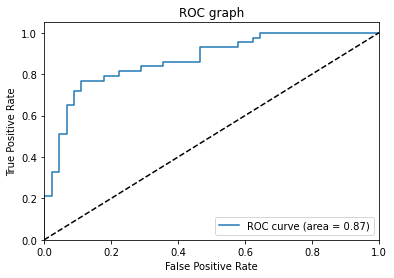

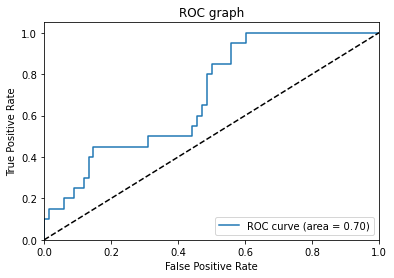

In [225]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc

y = label_binarize(y, classes=[0,1,2])
n_classes = 3

# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC graph')
    plt.legend(loc="lower right")
    plt.show()